# XPN 2020

After taking a year off from playlists, they are back.
This time instead of an A-Z walk though their catalog
[WXPN](https://www.xpn.org) is back to listener curated lists
with this years [2002 Countdown](https://xpn.org/music-artist/885-countdown/2020/).
This time the station is doing their own stats page,
[2020 Countdown, by the Numbers](https://thekey.xpn.org/wxpn-2020-numbers/).
But for fun, I'll still do something.

In [1]:
%matplotlib inline
from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide();
    } else {
        $('div.input').show();
    }
        code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

## Status

* It's just over a day and it's been a busy week, so I'm going to start with the basics.  Hopefully I'll figure out some interesting thigns to do once I've got things running.


## Loading the Data

Most people are probably not too interested in how I pull the data, clean it and augment it.
If you do the details are in my [Data Loading notebook](DataLoading.ipynb).
If you want a copy of the raw data to play with yourself, 
feel free to look at [xpn2020.csv](./data/xpn2020.csv).
If you do something interesting with the data,
please let me know.
And tell the station and post to [twitter](https://twitter.com) with the hash tag `#XPN2020`.
I'm sure other listeners will be glad to see what you have done.

In [2]:
import pandas as pd
from datetime import date, datetime, time, timedelta
from os import path
data_dir = './data'
playlist_file = path.join(data_dir, 'xpn2020.csv')
playlist = pd.read_csv(playlist_file)

playlist['Air Time'] = pd.to_datetime(playlist['Air Time'], errors='coerce')
last_play = playlist.loc[playlist['Air Time'].idxmax()]
end_time = last_play['Air Time'] + timedelta(seconds = 60 * last_play['Duration'])
HTML('<p>So far, as of %s, we have seen %d tracks with %d unique titles, from %d artists.</p>' %\
    (end_time.strftime('%b %d %I:%M%p'),
     len(playlist),
     playlist.describe(include='all')['Title']['unique'], 
     playlist.describe(include='all')['Artist']['unique']
     ))

## Data Analysis

### Most Popular Artists

It's always interesting to see which artists show up the most.
There tends to be bias to nostalgia.
But there's usually some new stuff mixed in.

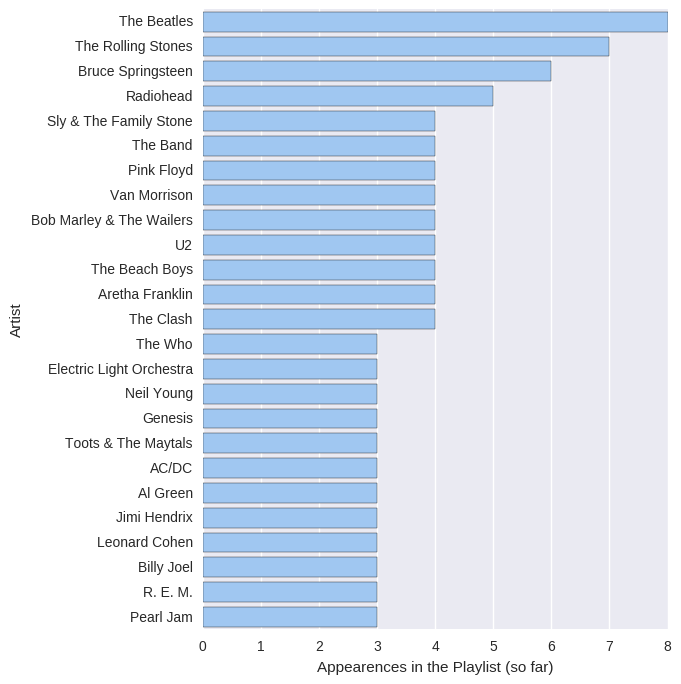

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
c = playlist['Artist'].value_counts()
artists = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('Artist', 'Count'))
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
sns.barplot(y='Artist', x='Count', data=artists[artists['Count'] > 2], color='b')
ax.set(xlabel="Appearences in the Playlist (so far)")

### Songs by Year

[XPN](https://xpn.org) plays a lot of new music.
I count on them to introduce me to what the cool kids are listening to.
Frankly it's silly to go through life only listening to what you listed to in highschool.
Nostalgia, being what it is, the countdowns tend to skew old.

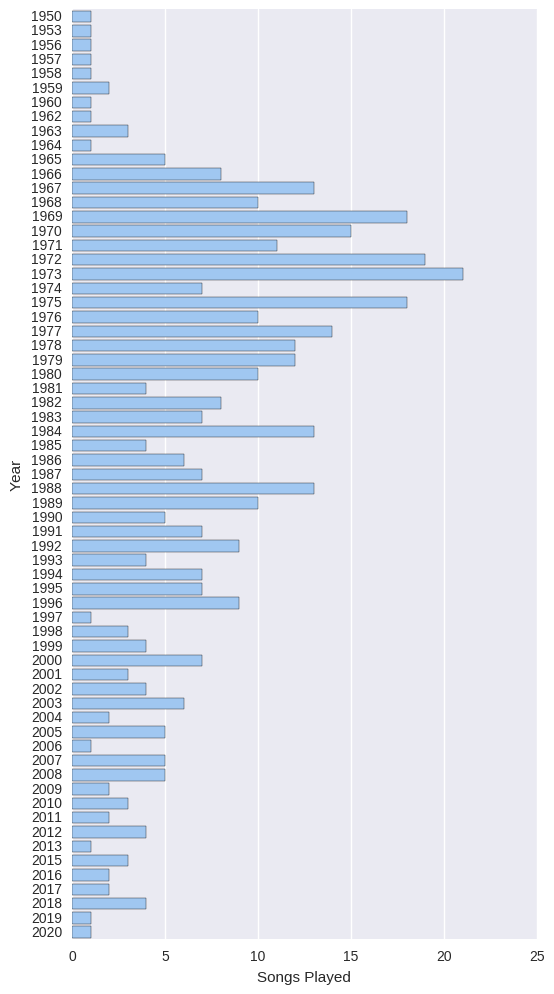

In [4]:
f, ax = plt.subplots(figsize=(6, 12))
sns.set_color_codes('pastel')
sns.countplot(y='Year', data=playlist[playlist['Year'] > 0], color='b')
ax.set(xlabel="Songs Played", ylabel="Year")

### Artists Who Have Played For The Most Time

This isn't overly accurate, as it is based on the successive start times
in the playlist, and those only have one minute granularity.
Plus the hosts do pause to talk every few songs,
and that isn't factored out.
But it's the best we have.
Besides someone asked about this.
Playing more songs helps with total duration,
but so does long songs.

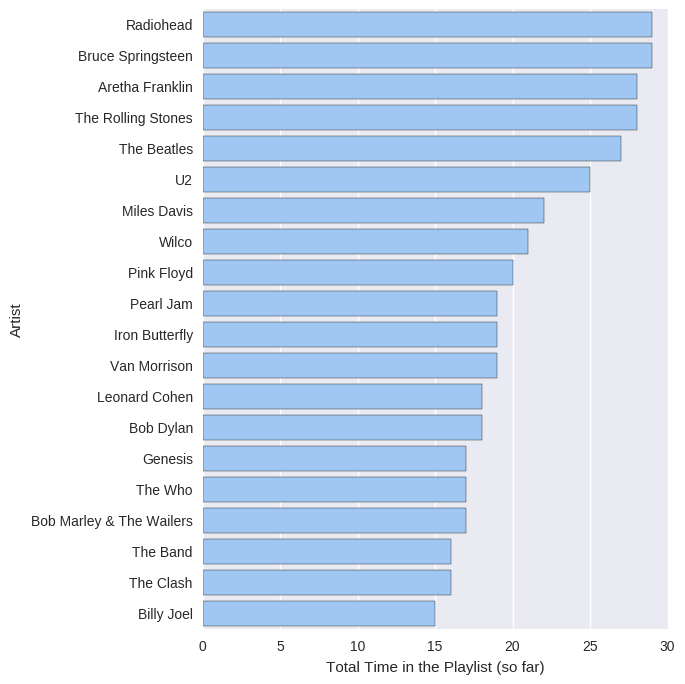

In [5]:
artist_durations = playlist.groupby('Artist')['Duration'].sum().to_frame()
artist_durations = artist_durations.reset_index()
artist_durations = artist_durations.sort_values(by='Duration', ascending=False)

f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
sns.barplot(y='Artist', x='Duration', data=artist_durations.head(20), color='b')
ax.set(xlabel="Total Time in the Playlist (so far)")

### Longest Songs

We can look at which songs took the longest.
During the playlist, sometimes missing data creates artificial "long tracks."
Generally these get corrected, so what's here now seems legit.


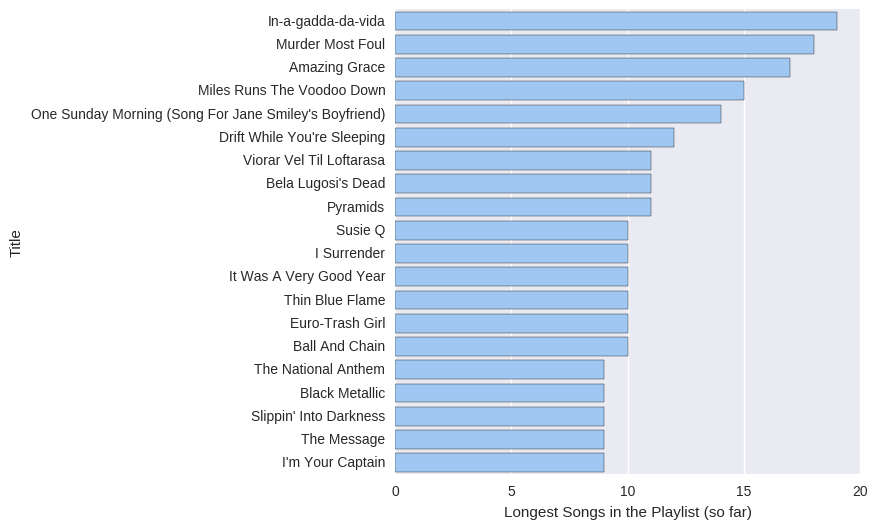

In [6]:
long_songs = playlist.sort_values(by='Duration', ascending=False)
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.barplot(y='Title', x='Duration', data=long_songs.head(20), color='b')
ax.set(xlabel="Longest Songs in the Playlist (so far)")